# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [479]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [480]:
import dataclasses as dt

In [481]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import cmasher as cmm
import colorcet as cc
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca
from matplotlib import gridspec

ca.finalize_libca()

%matplotlib inline

In [482]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [483]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / "nf_fwhm_pl_pi"
save_dir.mkdir(exist_ok=True)

### This is the analysis part

In [484]:
trials_file = save_dir / "trials.joblib"

In [485]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [486]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/sim_peak_fwhm_nlpi")
base_out_dir.mkdir(exist_ok=True)

In [487]:
out_dir = base_out_dir / "noise_free"
out_dir.mkdir(exist_ok=True)

In [488]:
ground_file = save_dir / "focused_beam.joblib"
ground_data = joblib.load(ground_file)

In [489]:
ground_dw = ground_data["dw"]
ground_hist = ground_data["hist"]

In [622]:
ground = {
    "FWHM": opt_common._get_fwhm_from_dw(ground_dw),
    "PL": opt_common._get_peak_distance_from_dw(ground_dw),
    "NLPI": -np.log(opt_common._get_peak_intensity_from_dw(ground_dw)),
}
ground

{'FWHM': 0.006001647722969481,
 'PL': 0.001105658956279055,
 'NLPI': -4.567518882421333}

In [704]:
study = analysis.create_study_from_trials(trials_file, n_objectives=3)
n_steps = len(study.trials)

[I 2023-08-11 00:12:41,319] A new study created in memory with name: no-name-ad544660-55ad-484e-aee2-280e9fb4b323


Assuming minimization for all objectives.


In [705]:
n_steps

120

In [706]:
hist_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi')

In [707]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")[:n_steps]

In [708]:
study.trials[0]

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.019349455501968378, 0.11158756574609786, -2.9824323543856006], datetime_start=datetime.datetime(2023, 8, 10, 23, 20, 11, 410186), datetime_complete=datetime.datetime(2023, 8, 10, 23, 20, 22, 242705), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapper object at 0x7f80d30d5c10>, 'ws': 43.12473705659644}, system_attrs={'fixed_params': {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}, 'constraints': (-1,)}, intermediate_values={}, distributions={'hb_1': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_2': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_pitch': FloatDistribution(high=0.00199, log=False, low=-0.002, step=None), 'hb_trans': FloatDistribution(high=0.0299

In [709]:
maxcount = np.max(ground_hist.data_2D)
maxcount2 = np.max([h.data_2D for h in hists])

In [710]:
maxcount = np.maximum(maxcount, maxcount2)

In [711]:
m2 = apu.CMAP

{'h_sigma': 0.0021204598553324944, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.0002161484017770281, 'h_peak': -0.0010283203124999973, 'v_sigma': 0.0022897839769969314, 'v_fwhm': 0.0024374999999999813, 'v_centroid': -0.001826363699928456, 'v_peak': 0.0004062499999999969, 'integral_intensity': 3667.0606517821116, 'peak_intensity': 96.30486939944767, 'gaussian_fit': {}}


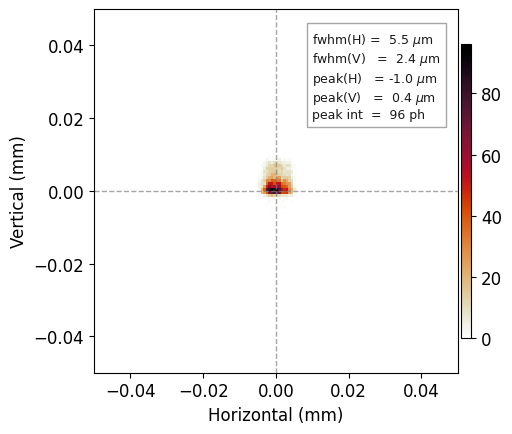

In [712]:
dwd = dict(ground_dw._DictionaryWrapper__dictionary)
print(dwd)
hist = ground_hist
plt.figure(figsize=[5, 5], constrained_layout=True)
ax = plt.gca()

plt.pcolormesh(hist.hh, hist.vv[::-1], hist.data_2D.T, cmap=m2, rasterized=True)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)
# ax.set_yticklabels([])


ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
#plt.savefig(f"{out_dir}/focussed.svg", bbox_inches="tight", dpi=600)
# plt.title('Initial')
plt.show()

Trial number 0
Trial values: peak_distance 1.116e-01 fwhm 1.935e-02 int -2.982e+00
Trial dw:
{'h_sigma': 0.016896796393669283, 'h_fwhm': 0.01919531249999995, 'h_centroid': -0.08576996428144726, 'h_peak': -0.09426269531250003, 'v_sigma': 0.031105580862982686, 'v_fwhm': 0.0024374999999999813, 'v_centroid': -0.05620785860501022, 'v_peak': 0.05971874999999999, 'integral_intensity': 3664.305970524787, 'peak_intensity': 19.735762679155922, 'gaussian_fit': {}}
Actual fwhm 0.019349455501968378


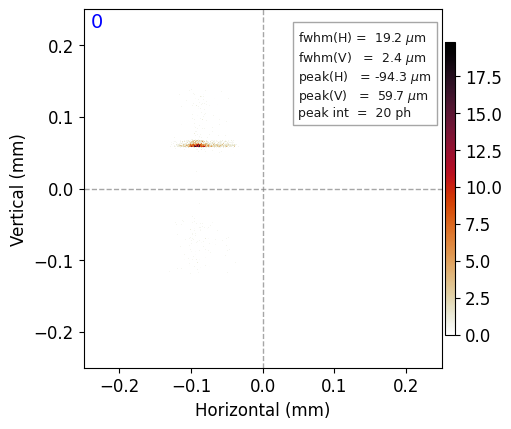

In [713]:
t = study.trials[0]
print("Trial number", t.number)
print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
print("Trial dw:")

dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
print(dwd)
print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
hist = hists[t.number]
plt.figure(figsize=[5, 5], constrained_layout=True)
ax = plt.gca()

plt.pcolormesh(hist.hh, hist.vv[::-1], hist.data_2D.T, cmap=m2, rasterized=True)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)
# ax.set_yticklabels([])


ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.text(0.02, 0.95, 0, fontsize=14, color="blue", transform=ax.transAxes)
#plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
# plt.title('Initial')
plt.show()

In [714]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [715]:
nash_trial

FrozenTrial(number=32, state=TrialState.COMPLETE, values=[0.007387275694977349, 0.0037207663062630795, -3.74630824710183], datetime_start=datetime.datetime(2023, 8, 10, 23, 27, 32, 887818), datetime_complete=datetime.datetime(2023, 8, 10, 23, 27, 47, 894682), params={'hb_1': -11.0, 'hb_2': 10.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': 0.010700000000000001, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.0063}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapper object at 0x7f83304bfa00>, 'ws': 1.0825296942647902}, system_attrs={'constraints': (-1,)}, intermediate_values={}, distributions={'hb_1': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_2': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_pitch': FloatDistribution(high=0.00199, log=False, low=-0.002, step=None), 'hb_trans': FloatDistribution(high=0.0299, log=False, low=-0.03, step=None), 'vb_bender': FloatDistribution(

In [716]:
ground_mots = {'hb_1': -168, 'hb_2': -161, 'hb_pitch': 0.1719, 'hb_trans': 0, 'vb_bender': 419, 'vb_pitch': 0.1719, 'vb_trans': 0}

In [717]:
random_init = {'hb_1': -174.8,
 'hb_2': -165.6,
 'hb_pitch': 0.17247733853924987,
 'hb_trans': 0.0106,
 'vb_bender': 416.8,
 'vb_pitch': 0.17155733853924987,
 'vb_trans': 0.0029}

In [718]:
safe = lambda x: 0 if x is None else x

Trial number 20
Trial values: peak_distance 1.755e-02 fwhm 7.969e-03 int -4.035e+00
Trial dw:
{'h_sigma': 0.003323312597069551, 'h_fwhm': 0.006855468749999982, 'h_centroid': -0.00275588197105776, 'h_peak': -0.0017138671874999956, 'v_sigma': 0.01074161959917555, 'v_fwhm': 0.004062499999999969, 'v_centroid': 0.01601892196848054, 'v_peak': -0.017468749999999977, 'integral_intensity': 3658.4961203038824, 'peak_intensity': 56.526732511172455, 'gaussian_fit': {}}
Trial mots
{'hb_1': -189.8, 'hb_2': -160.6, 'hb_pitch': 0.17160733853924987, 'hb_trans': 0.0182, 'vb_bender': 420.8, 'vb_pitch': 0.17073733853924988, 'vb_trans': 0.0148}


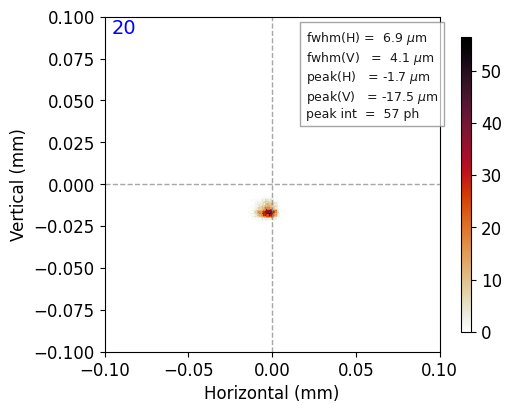

Trial number 32
Trial values: peak_distance 3.721e-03 fwhm 7.387e-03 int -3.746e+00
Trial dw:
{'h_sigma': 0.005802976776973986, 'h_fwhm': 0.006169921874999984, 'h_centroid': -0.006600659587165455, 'h_peak': -0.0023994140624999938, 'v_sigma': 0.014469247934732506, 'v_fwhm': 0.004062499999999969, 'v_centroid': 0.0025342908637043192, 'v_peak': -0.0028437499999999782, 'integral_intensity': 3694.325222467239, 'peak_intensity': 42.364394076861814, 'gaussian_fit': {}}
Trial mots
{'hb_1': -185.8, 'hb_2': -155.6, 'hb_pitch': 0.17160733853924987, 'hb_trans': 0.0213, 'vb_bender': 419.8, 'vb_pitch': 0.17083733853924987, 'vb_trans': 0.0092}


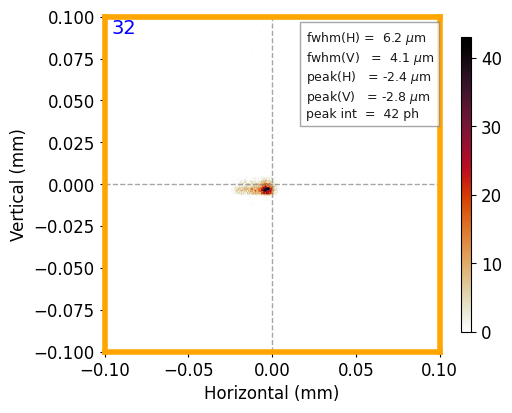

Trial number 39
Trial values: peak_distance 2.658e-03 fwhm 1.210e-02 int -3.539e+00
Trial dw:
{'h_sigma': 0.004446149812822689, 'h_fwhm': 0.01165429687499997, 'h_centroid': -0.004863265177057397, 'h_peak': -0.0017138671874999956, 'v_sigma': 0.0033123398035781854, 'v_fwhm': 0.003249999999999975, 'v_centroid': -0.0034556395683042924, 'v_peak': 0.0020312499999999845, 'integral_intensity': 3696.8342142383103, 'peak_intensity': 34.42643466092624, 'gaussian_fit': {}}
Trial mots
{'hb_1': -187.8, 'hb_2': -160.6, 'hb_pitch': 0.17160733853924987, 'hb_trans': 0.0223, 'vb_bender': 420.8, 'vb_pitch': 0.17093733853924986, 'vb_trans': 0.011100000000000006}


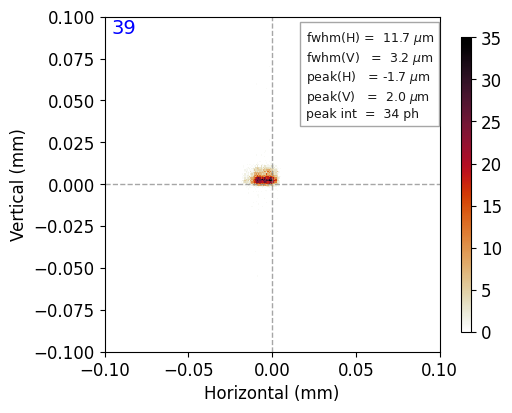

Trial number 79
Trial values: peak_distance 1.998e-02 fwhm 6.974e-03 int -4.009e+00
Trial dw:
{'h_sigma': 0.002800833033257726, 'h_fwhm': 0.006169921874999984, 'h_centroid': 0.002860239649234148, 'h_peak': 0.0017138671874999956, 'v_sigma': 0.00750338947587693, 'v_fwhm': 0.003249999999999975, 'v_centroid': -0.022141060838019908, 'v_peak': 0.019906250000000014, 'integral_intensity': 3663.4085676774803, 'peak_intensity': 55.08951201712843, 'gaussian_fit': {}}
Trial mots
{'hb_1': -187.8, 'hb_2': -164.6, 'hb_pitch': 0.17161733853924988, 'hb_trans': 0.0162, 'vb_bender': 421.8, 'vb_pitch': 0.17073733853924988, 'vb_trans': -0.0248}


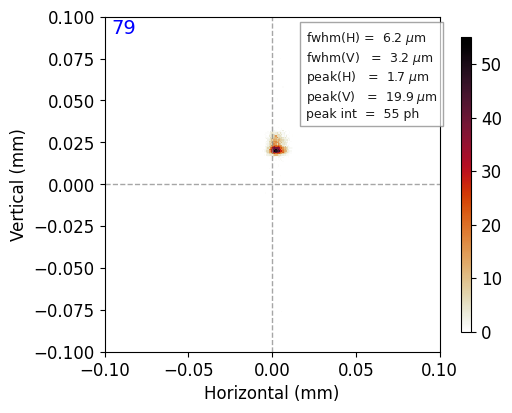

Trial number 91
Trial values: peak_distance 1.237e-02 fwhm 6.841e-03 int -3.315e+00
Trial dw:
{'h_sigma': 0.01140943670512763, 'h_fwhm': 0.0047988281249999876, 'h_centroid': -0.002574664678112392, 'h_peak': -0.0037705078124999902, 'v_sigma': 0.022361152724861517, 'v_fwhm': 0.004874999999999963, 'v_centroid': 0.007475442243379282, 'v_peak': -0.011781250000000021, 'integral_intensity': 3671.7390846449666, 'peak_intensity': 27.51315218064359, 'gaussian_fit': {}}
Trial mots
{'hb_1': -186.8, 'hb_2': -153.6, 'hb_pitch': 0.17163733853924987, 'hb_trans': 0.0194, 'vb_bender': 412.8, 'vb_pitch': 0.17067733853924988, 'vb_trans': 0.0016000000000000007}


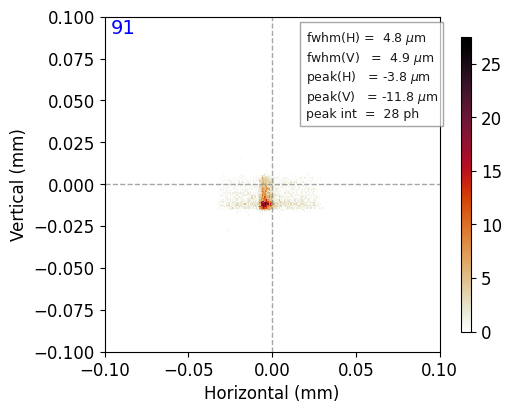

Trial number 97
Trial values: peak_distance 2.060e-03 fwhm 7.969e-03 int -3.537e+00
Trial dw:
{'h_sigma': 0.009716896791640907, 'h_fwhm': 0.006855468749999982, 'h_centroid': -0.003384650948236165, 'h_peak': 0.0003427734374999991, 'v_sigma': 0.006458483135977921, 'v_fwhm': 0.004062499999999969, 'v_centroid': -0.0022525312985762214, 'v_peak': 0.0020312499999999845, 'integral_intensity': 3708.854785573654, 'peak_intensity': 34.37330657208817, 'gaussian_fit': {}}
Trial mots
{'hb_1': -186.8, 'hb_2': -150.6, 'hb_pitch': 0.17152733853924987, 'hb_trans': 0.023600000000000003, 'vb_bender': 419.8, 'vb_pitch': 0.17091733853924987, 'vb_trans': 0.010700000000000001}


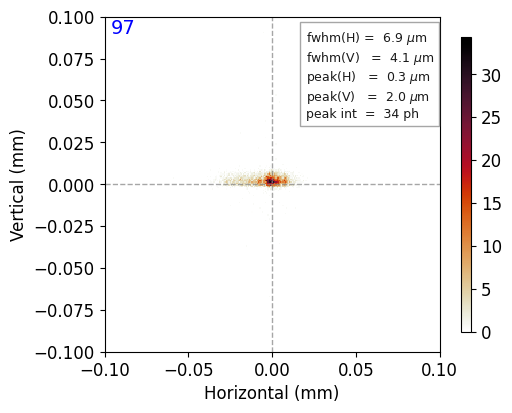

Trial number 101
Trial values: peak_distance 1.274e-02 fwhm 5.796e-03 int -3.911e+00
Trial dw:
{'h_sigma': 0.015038627639028398, 'h_fwhm': 0.0047988281249999876, 'h_centroid': -0.02100264442574857, 'h_peak': -0.012682617187500023, 'v_sigma': 0.009035735936054846, 'v_fwhm': 0.003249999999999975, 'v_centroid': 0.00021158694127532715, 'v_peak': -0.0012187499999999907, 'integral_intensity': 3701.828482188704, 'peak_intensity': 49.962285207456816, 'gaussian_fit': {}}
Trial mots
{'hb_1': -186.8, 'hb_2': -143.6, 'hb_pitch': 0.17161733853924988, 'hb_trans': 0.025300000000000003, 'vb_bender': 416.8, 'vb_pitch': 0.17111733853924987, 'vb_trans': 0.029700000000000004}


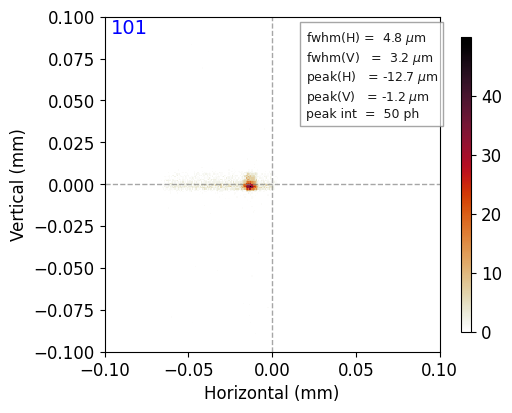

Trial number 119
Trial values: peak_distance 6.822e-03 fwhm 7.387e-03 int -3.794e+00
Trial dw:
{'h_sigma': 0.004896068017605263, 'h_fwhm': 0.006169921874999984, 'h_centroid': 0.008577762819123775, 'h_peak': 0.006512695312499983, 'v_sigma': 0.008662768941871785, 'v_fwhm': 0.004062499999999969, 'v_centroid': -0.003234885333257554, 'v_peak': 0.0020312499999999845, 'integral_intensity': 3651.4239674134087, 'peak_intensity': 44.42077248120615, 'gaussian_fit': {}}
Trial mots
{'hb_1': -185.8, 'hb_2': -168.6, 'hb_pitch': 0.17162733853924989, 'hb_trans': 0.014300000000000002, 'vb_bender': 417.8, 'vb_pitch': 0.17071733853924986, 'vb_trans': -0.006699999999999998}


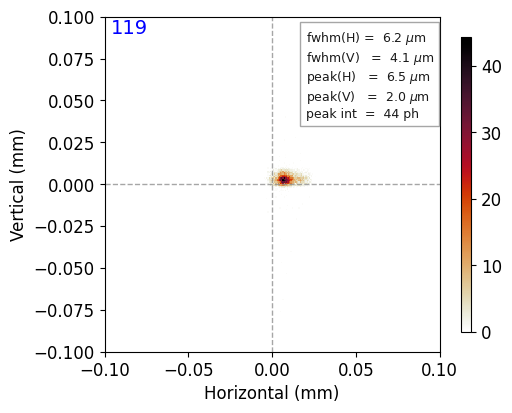

In [719]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
    print("Trial dw:")
    
    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dwd)

    print('Trial mots')
    print({m: random_init[m] + v for m,v in t.params.items()})
    
    plt.figure(figsize=[5, 5], constrained_layout=True)
    plt.pcolormesh(
        hists[t.number].hh,
        hists[t.number].vv,
        hists[t.number].data_2D.T[::-1],
        cmap=m2,
        rasterized=True,
    )
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.xlabel("Horizontal (mm)")
    plt.ylabel("Vertical (mm)")
    # plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect("equal")

    
    text = (
        rf"{'fwhm(H)':<6} = {safe(dwd['h_fwhm']) * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'fwhm(V)':<9} = {safe(dwd['v_fwhm']) * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(H)':<9} = {safe(dwd['h_peak']) * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(V)':<9} = {safe(dwd['v_peak']) * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak int':<9} = {dwd['peak_intensity']: 3.0f} ph"
    )
    ax.text(
        0.6,
        0.7,
        text,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        transform=ax.transAxes,
    )
    
    plt.text(0.02, 0.95, t.number, fontsize=14, color="blue", transform=ax.transAxes)
    # plt.savefig(f"{out_dir}/pareto_{t.number}.svg", bbox_inches="tight", dpi=600)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.show()

# 

In [620]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [621]:
c2

[23, 24, 64, 70, 101, 110]

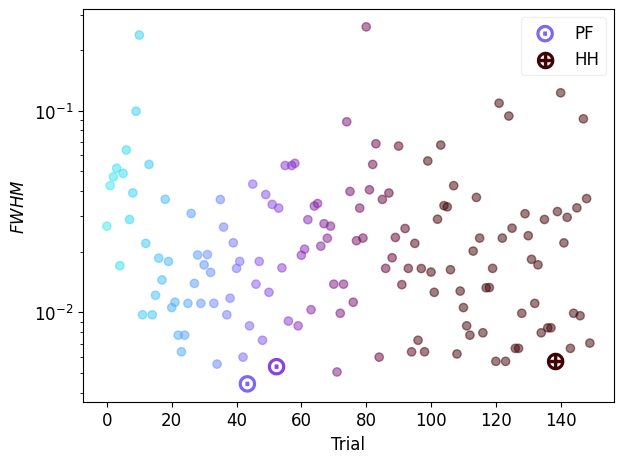

In [469]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure(dpi=100)

xfn  = lambda x: [xval for xval in x if study.trials[xval].values is not None]
yfn = lambda x: [study.trials[xval].values[0] for xval in x if study.trials[xval].values is not None]



plt.scatter(xfn(c3), yfn(c3), c=xfn(c3), cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100), rasterized=True)
plt.scatter(xfn(c2), yfn(c2), c=xfn(c2), cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF", rasterized=True)
plt.scatter(
    xfn(c1), yfn(c1), c=xfn(c1), cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="HH", rasterized=True
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

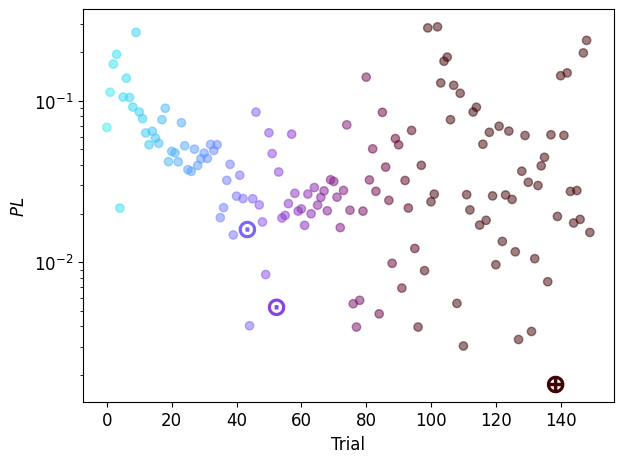

In [470]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()

xfn  = lambda x: [xval for xval in x if study.trials[xval].values is not None]
yfn = lambda x: [study.trials[xval].values[1] for xval in x if study.trials[xval].values is not None]



plt.scatter(xfn(c3), yfn(c3), c=xfn(c3), cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(xfn(c2), yfn(c2), c=xfn(c2), cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    xfn(c1), yfn(c1), c=xfn(c1), cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="HH"
)


plt.xlabel("Trial")
plt.ylabel("$PL$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

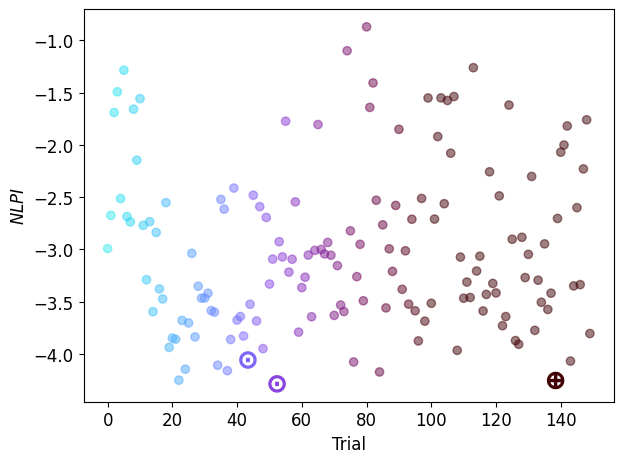

In [471]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()

xfn  = lambda x: [xval for xval in x if study.trials[xval].values is not None]
yfn = lambda x: [study.trials[xval].values[2] for xval in x if study.trials[xval].values is not None]



plt.scatter(xfn(c3), yfn(c3), c=xfn(c3), cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(xfn(c2), yfn(c2), c=xfn(c2), cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    xfn(c1), yfn(c1), c=xfn(c1), cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="HH"
)


plt.xlabel("Trial")
plt.ylabel("$NLPI$")
plt.tight_layout()
plt.show()

In [472]:
ground

{'FWHM': 0.006001647722969481,
 'PL': 0.0005315380437518685,
 'NLPI': -4.533626474945197}

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_16841/1559331091.py:29: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.462583681393228 4.352882222222222


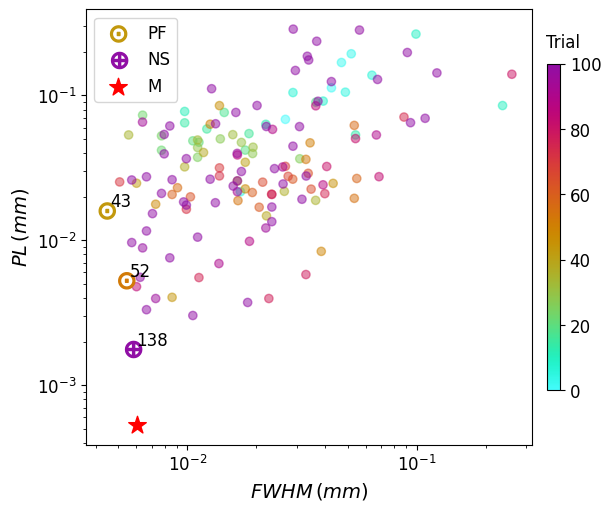

In [473]:

cfn  = lambda x: [xval for xval in x if study.trials[xval].values is not None]
yfn = lambda x, it: [study.trials[xval].values[it] for xval in x if study.trials[xval].values is not None]

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(yfn(c3, 0), yfn(c3, 1), c=cfn(c3), cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    yfn(c2, 0), yfn(c2, 1), c=cfn(c2), cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    yfn(c1, 0), yfn(c1, 1), c=cfn(c1), cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(yfn([t.number], 0)[0], yfn([t.number], 1)[0]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$PL\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

plt.scatter(ground["FWHM"], ground["PL"], color="red", marker="*", s=175, label="M")
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
#plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

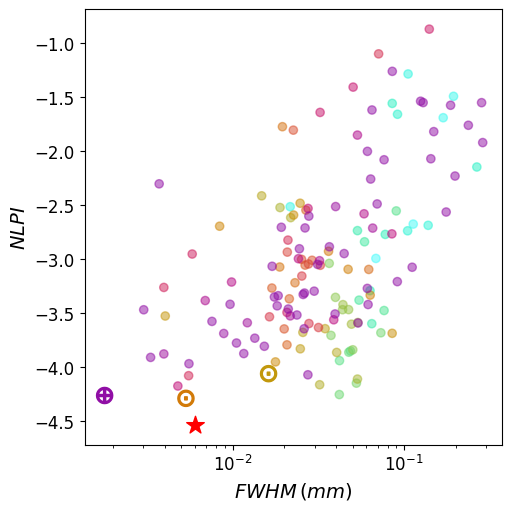

In [474]:
plt.figure(figsize=[5, 5], constrained_layout=True)
plt.scatter(yfn(c3, 1), yfn(c3, 2), c=cfn(c3), cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    yfn(c2, 1), yfn(c2, 2), c=cfn(c2), cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    yfn(c1, 1), yfn(c1, 2), c=cfn(c1), cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xscale("log")
# plt.yscale('log')
plt.xlabel("$FWHM\, (mm)$", fontsize=14)
plt.ylabel("$NLPI$", fontsize=14)

plt.scatter(ground["FWHM"], ground["NLPI"], color="red", marker="*", s=175, label="M")
# plt.legend(loc='best')
# plt.tight_layout()

#plt.savefig(f"{out_dir}/pareto_fwhm_nlpi.svg", bbox_inches="tight", dpi=600)
plt.show()

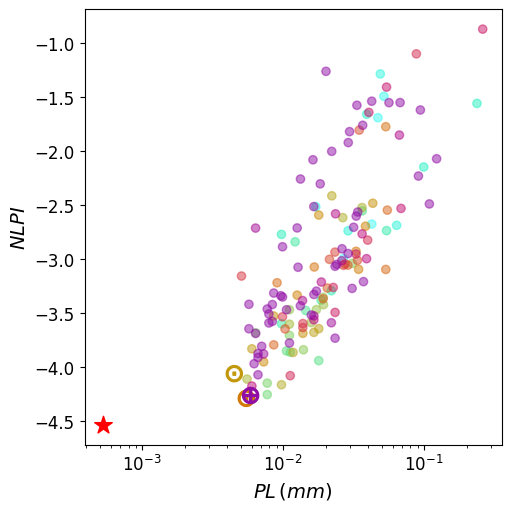

In [475]:
plt.figure(figsize=[5, 5], constrained_layout=True)
plt.scatter(yfn(c3, 0), yfn(c3, 2), c=cfn(c3), cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    yfn(c2, 0), yfn(c2, 2), c=cfn(c2), cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    yfn(c1, 0), yfn(c1, 2), c=cfn(c1), cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xscale("log")
# plt.yscale('log')
plt.xlabel("$PL\,(mm)$", fontsize=14)
plt.ylabel("$NLPI$", fontsize=14)

plt.scatter(ground["PL"], ground["NLPI"], color="red", marker="*", s=175, label="M")
# plt.legend(loc='best')
# plt.tight_layout()

#plt.savefig(f"{out_dir}/pareto_pl_nlpi.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [476]:
props = apu.AnalyzedProps(study, nash_trial, max_count=maxcount, min_count=1, xylim=0.1, photon_count_str="3.0f")

In [477]:
nash_idx, nash_trial.number

(2, 138)

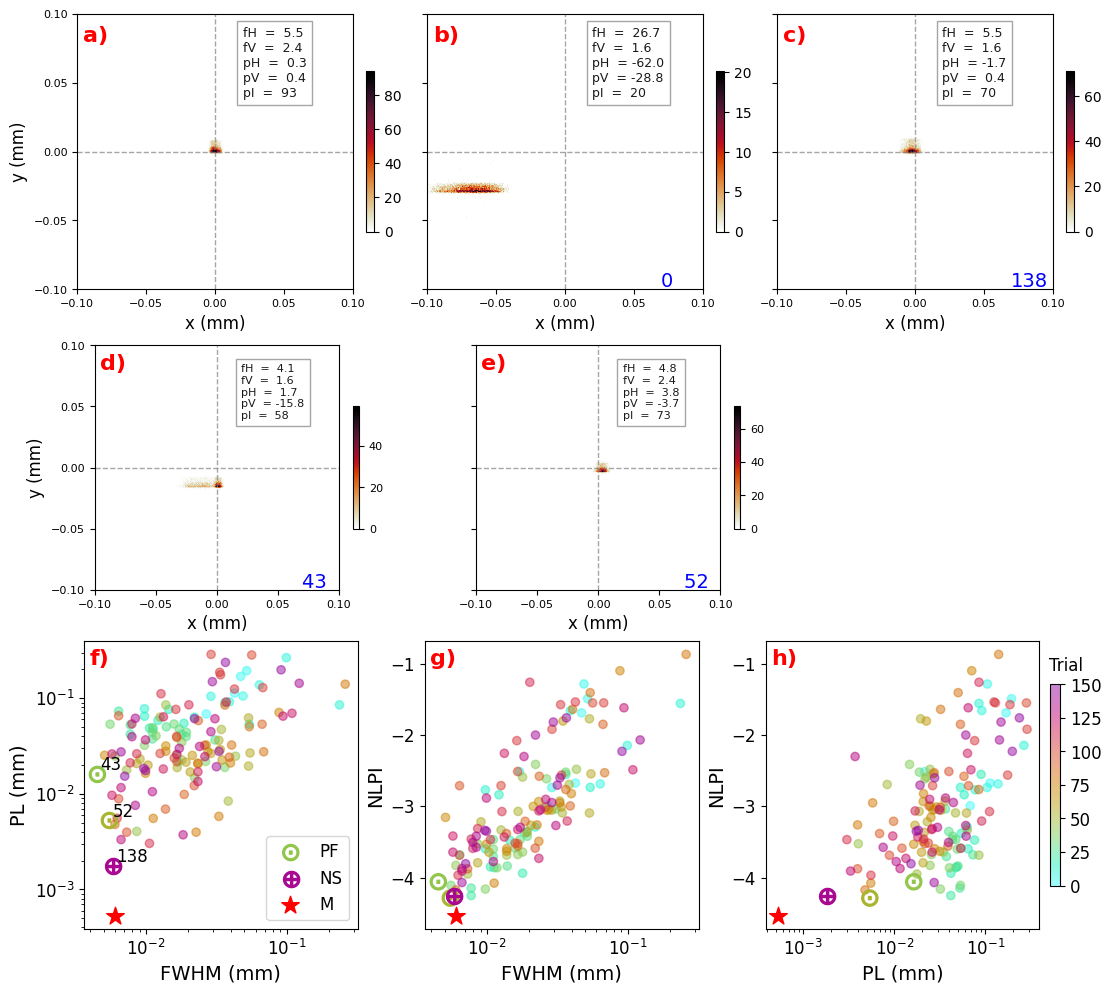

In [478]:
fig = plt.figure(figsize=[11, 10], layout="constrained")
gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.35, 0.3, 0.35])


# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

axs0 = gss0.subplots(sharex=True, sharey=True)


cmesh0, sublabel = apu.plot_hist_2d(props, axs0[0], ground_hist, ylabel=True)
apu.add_text_to_hist(props, axs0[0], ground_dw, ground_hist)


cmesh1, sublabel = apu.plot_hist_2d(props, axs0[1], hists[0], study_num=0, sublabel=sublabel)
apu.add_text_to_hist(props, axs0[1], study.trials[0].user_attrs["dw"], hists[0])

cmesh2, sublabel = apu.plot_hist_2d(props, axs0[2], hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel)
apu.add_text_to_hist(props, axs0[2], study.trials[nash_trial.number].user_attrs["dw"], hists[nash_trial.number])
# _, sublabel = apu.

for ix, cmesh in enumerate([cmesh0, cmesh1, cmesh2]):
    cbar = fig.colorbar(cmesh, ax=axs0[ix], pad=0.005, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)
    axs0[ix].locator_params(nbins=4)

# middle row
gss1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1])

axs1 = gss1.subplots(sharex=True, sharey=True)
axs1 = axs1.flatten()
axs1[-1].set_axis_off()

_trials = [t for t in study.best_trials if t.number != nash_trial.number]


for ix, t in enumerate(_trials):
    ylabel = True if ix == 0 else False
    cmesh, sublabel = apu.plot_hist_2d(
        props, axs1[ix], hists[t.number], study_num=t.number, sublabel=sublabel, ylabel=ylabel
    )
    apu.add_text_to_hist(props, axs1[ix], dw=t.user_attrs["dw"], hist=hists[t.number], fontsize=8)
    cbar = fig.colorbar(cmesh, ax=axs1[ix], pad=0.005, shrink=0.5)
    cbar.ax.tick_params(labelsize=8)
    axs1[ix].locator_params(nbins=4)

# bottom row

gss2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2])
axs2 = gss2.subplots()

cscatter, sublabel = apu.plot_pareto_2d(
    props, axs2[0], "FWHM", "PL", sublabel=sublabel, ground=ground, annotate=True, legend=True
)
_, sublabel = apu.plot_pareto_2d(props, axs2[1], "FWHM", "NLPI", sublabel=sublabel, ground=ground)
_, sublabel = apu.plot_pareto_2d(props, axs2[2], "PL", "NLPI", sublabel=sublabel, ground=ground)

cbar = plt.colorbar(cscatter, ax=axs2, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, n_steps + 10, "Trial")

#fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.05, wspace=0.01)
plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{out_dir}/fig_combined.png", bbox_inches="tight", dpi=600)
plt.show()